# <center> Raport lokalnego przewoźnika Wesoły Autobus S.A.
## <center> Analiza płynności firmy w zależności od ceny biletów i liczby zakupionych autobusów

<br>Zaawansowane Modelowanie Symulacyjne
<br>234060-0723

**Autorzy**
<br>Filip Mordarski, 76671 
<br>Damian Głowacki, 72384 
<br>Mateusz Dalba, 68734
<br>Dorota Szczęsna, 72569

## 1. Executive summary

## 2. Opis organizacji

<br> Symulacja jest przeprowadzana dla lokalnego przewoźnika Wesoły autobus S.A. 

## 3. Opis problemu
<br>W związku ze wzrostem zatrudnienia w lokalnej fabryce firma planuje zoptymalizować istniejącą linię łączącą lokalne miejscowości z fabryką, głównym miejscem pracy większości mieszkańców. Obecnie istniejące połączenie jest nieefektywne, kursuje za mało autobusów i nie wszyscy pasażerowie są w stanie pojechać autobusem o zaplanowanej godzinie. Dodatkowo zyski firmy są na zbyt niskim poziomie, aby firma mogła dobrze prosperować i inwestować w dalszy rozwój.

Prezez firmy Wesoły autobus S.A. zwrócił się do nas z prośbą o przygotowanie raportu z rekomendacjami na usprawnienie linii łączącej Małe Bobry z fabryką. Przekazał nam informację, że dzienna liczba pasażerów przyjmuje rozkład gamma. Klienci także są wrażliwi na wartość ceny biletu, jeżeli cena będzie za wysoka to pojadą do pracy samochodami, pociągiem lub taksówkami.


In [2]:
import numpy as np
import numpy.random as random
import random as r
from collections import OrderedDict
import pandas as pd
from statistics import mean 
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
stops = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2", "Małe Bobry_2"]

In [8]:
# Nowa funkcja ceny - wybieramy tą
def f(cena=0):
    if cena <= 6:
        wspolczynnik = round(4/(1/2*cena+1)-1,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [9]:
def simulate_passengers(cena):
    passengers = {}
    for hour in range(24):
        passengers[hour] = {}
    for stop in stops:
        if stop != "Małe Bobry_2":
            wsp_ceny=f(cena)
            if stop == "Dworzec":
                number_passengers_in = random.gamma(6, 2, size=int(1200*wsp_ceny)).round(0)
                number_passengers_in = number_passengers_in[(number_passengers_in >=0) & \
                                                            (number_passengers_in <=23)]
                number_passengers_out = random.gamma(6, 2, size=int(1200*wsp_ceny)).round(0)
                number_passengers_out = number_passengers_out[(number_passengers_out >=0) & \
                                                              (number_passengers_out <=23)]
            elif '2' in stop:
                number_passengers_in = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
                number_passengers_out = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = np.array([24-value for value in number_passengers_out])
            elif stop == "Fabryka": 
                number_passengers_in = random.gamma(8, 1, size=int(1200*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
            else: 
                number_passengers_in = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
            for hour in range(24):
                passengers[hour][stop] = {}
                passengers[hour][stop]["in"] = len(number_passengers_in[number_passengers_in == hour])
                if stop not in ["Małe Bobry", "Małe Bobry_2", "Fabryka"]:
                    passengers[hour][stop]["out"] = len(number_passengers_out\
                                                              [number_passengers_out == hour])
    return passengers

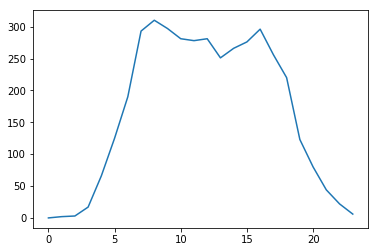

In [26]:
# Łaczna liczba pasażerów wsiadających
cena_biletu=2.8
lista_h = list(range(0,24))
lista_pass = []
pass_l = 0
for key,value in simulate_passengers(cena_biletu).items():
    pass_l = 0
    for k, v in value.items():
        pass_l += (v['in'])
    lista_pass.append(pass_l)
plt.plot(lista_h, lista_pass)

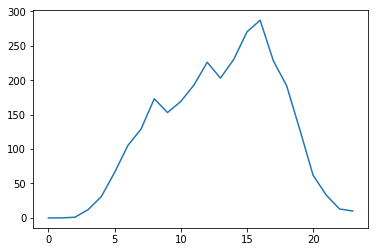

In [27]:
# Łaczna liczba pasażerów wysiadających

lista_h = list(range(0,24))
lista_pass_out = []
pass_l = 0
for key2,value2 in simulate_passengers(cena_biletu).items():
    pass_l = 0
    for k2, v2 in value2.items():
        if 'out' not in v2:
            pass_l += 0
        else:
            pass_l += v2['out']
    lista_pass_out.append(pass_l)
plt.plot(lista_h, lista_pass_out)

Text(0.5, 1.0, 'IN')

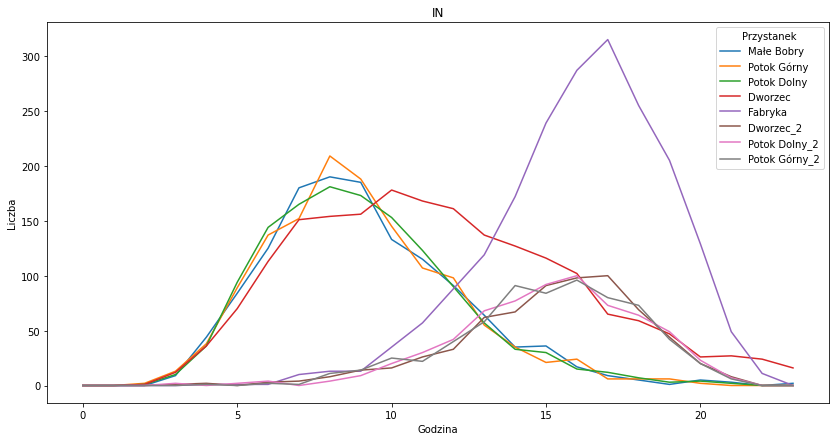

In [43]:
# Wykres dla 'IN'

lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []
for i in range(0,24):
    s = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2"]
    stops += s
lista_pass = []
for key,value in simulate_passengers(cena_biletu).items():
    for k, v in value.items():
        lista_pass.append(v['in'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba': lista_pass} )
fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba',hue='Przystanek').set_title('IN')

Text(0.5, 1.0, 'OUT')

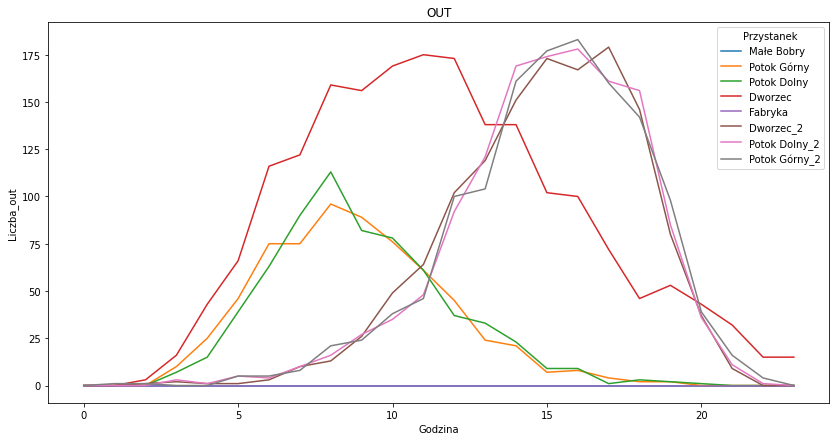

In [44]:
# Wykresy dla 'OUT'

lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []

for i in range(0,24):
    s = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2"]
    stops += s
        
lista_pass_out = []
for key2,value2 in simulate_passengers(cena_biletu).items():
    for k2, v2 in value2.items():
        if 'out' not in v2:
            lista_pass_out.append(0)
        else:
            lista_pass_out.append(v2['out'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba_out': lista_pass_out} )

fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba_out',hue='Przystanek').set_title('OUT')

In [11]:
def random_times(n, num_terms = None):
    output = []
    mean = n/num_terms
    for time in range(num_terms):
        if time+1 == num_terms:
            output.append(n - sum(output))
        else:
            output.append(round(random.normal(mean, mean*0.1), 0))
    return output

In [12]:
def model(hour, stats, buses, capacity):
    # filtruje słownik z liczbą pasażerów (na daną godzine)
    stats_hour = stats[hour]
    # inicjuję potrzebne słowniki
    stats_stops = {}
    bus_passengers = {}
    for bus in range(buses):
        bus_passengers[bus+1] = {}
        bus_passengers[bus+1]['in'] = []
        bus_passengers[bus+1]['out'] = []
    # tworzę tuplę z listami wsiadających oraz wysiadających pasażerów z danego busa
    # długość list = liczba busów
    for key, value in stats_hour.items():
        if 'out' in value:
            stats_stops[key] = (random_times(value['in'], buses), random_times(value['out'], buses))
        else:
            stats_stops[key] = (random_times(value['in'], buses),)
    # inicjuję finalną listę z przewiezionymi pasażerami przez konkretne busy
    bus_output = []
    for bus in range(buses):
        # liczba aktualnych pasażerów w busie
        passengers = 0
        # liczba w sumie przewiezionych pasażerów
        passengers_final = 0
        for key, value in stats_stops.items():
            bus_passengers[bus+1]['in'].append(value[0][bus])
            if len(value) > 1:
                bus_passengers[bus+1]['out'].append(value[1][bus])
            else:
                bus_passengers[bus+1]['out'].append(0)
        for i in range(len(bus_passengers[bus+1]['in'])):
            # i == 4 to rondo onz, zakładamy, że na rondzie ONZ wysiądą wszyscy
            if i == 4:
                passengers = 0
            else:
                passengers -= min(bus_passengers[bus+1]['out'][i], passengers)
            passengers_final += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
            passengers += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
        bus_output.append(passengers_final)
    return  bus_output

In [13]:
# Symulacja z arbitralnymi wartościami

def symulacja_init(iteration, cena_biletu, koszt_autobusu, list_buses, capacity):
    profits = []
    for i in range(iteration):
        profit = 0
        stats = simulate_passengers()
        for hour in range(24):
            passengers = model(hour, stats, list_buses[hour], capacity)
            profit += sum([value*cena_biletu for value in passengers])
            profit -= koszt_autobusu*list_buses[hour]
        profits.append(profit)
    return profits

In [14]:
def symulacja(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []
    for i in range(iteration):
        profit = 0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        for hour in range(24):
            hour_profit = []
            for bus in range(1, buses+1):
                passengers = model(hour, stats, bus, capacity)
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                hour_profit.append(profit)
            hour_bus.append(hour_profit.index(max(hour_profit))+1)
            profit = max(hour_profit)
        profits.append(profit)
        optimum_buses.append(hour_bus)
    return profits ,optimum_buses

## 5. Wyniki analizy

<br> W tej części raportu zostaną przedstawione wyniki analizy, które mają na celu wskazać optymalną liczbę autobusów na każdą godzinę dnia oraz cenę biletu.

### 5.1 Wybór optymalnej liczby autobusów dla każdej godziny
<br> Liczba pasażerów w danych godzinach nie jest stała i zależy od pory dnia. Dlatego ustalenie stałej liczby autobusów kursujących w każdej godzinie jest nieoptymalne. Poniżej przeprowadzono analizę optymalnej liczby autobusów dla danej godziny w zależności od ceny biletu i liczby dopuszczonych autobsuów (maksymalnie 6).

In [17]:
### Symulacja optymalnej liczby busów od ceny biletu, liczby busów i godziny
iteration=2
ceny =np.arange(0.0, 4.2,0.2)
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data1 = pd.DataFrame()

for p in ceny:
    for b in buses:
        for i in range(iteration):
            for h in range(24):
                data1 = data1.append({"Cena":p, "Dopuszczone busy": b, "Godzina":h,
                                    "liczba busów": symulacja(iteration, p, koszt_autobusu, b, capacity)[1][i][h]}, ignore_index=True)

#data1
#pd.set_option('display.max_rows', data1.shape[0]+1)
data1=data1.groupby(['Dopuszczone busy','Cena','Godzina'])['liczba busów'].median().round(0).reset_index()




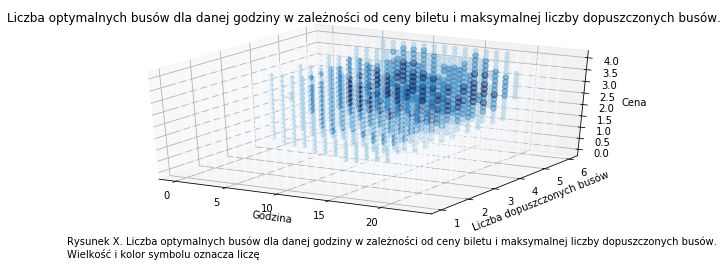

In [18]:
x_line=data1['Godzina']
y_line=data1['Dopuszczone busy']
z_line=data1['Cena']
l_b=data1['liczba busów']*10

fig = plt.figure(
    figsize=plt.figaspect(0.4)
)
ax = fig.add_subplot(1,1,1, projection='3d')
scat1=ax.scatter3D(x_line, y_line, z_line, 'gray', s=l_b,c=l_b, marker='o',cmap = cm.Blues)

ax.set_xlabel("Godzina")
ax.set_ylabel("Liczba dopuszczonych busów")
ax.set_zlabel("Cena")
ax.set_title("Liczba optymalnych busów dla danej godziny w zależności od ceny biletu i maksymalnej liczby dopuszczonych busów.",size=12)
fig.text(.1, -0.02, "Rysunek X. Liczba optymalnych busów dla danej godziny w zależności od ceny biletu i maksymalnej liczby dopuszczonych busów. \n"
                     "Wielkość i kolor symbolu oznacza liczę  \n", ha='left')
plt.show()

Analiza powyższego wykresu pozwala zauważyć, że w godzinach porannych oraz nocnych potrzeba jedynie jednego autobusu na trasie. Dodatkowo widzimy, że wraz ze wzrostem liczby dopuszczonej liczby busów na trasie wzrasta ich optymalna liczba w godzinach szczytowych. Oczywiście dla wyższych wartości ceny biletu, tak od 3,5 zł, liczba optymalnych autobusów zaczyna spadać, ponieważ klienci rezygnują. Poniższy wykres przedstawia dokładną liczbę optymalnych busów w ciągu dla optymalnej wartości biletu - 2,8 zł. Widzimy, że w godzinach dojazdu i powrótu z pracy potrzeba najwięcej kursujących autobusów, czyli 4 na godzinę, w ciągu dnia liczba ta spada do 3 na godzinę.

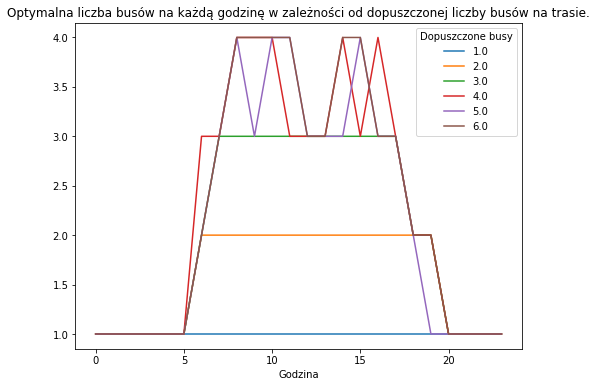

In [28]:
### Symulacja optymalnej liczby busów przy zadanej cenie biletu, koszcie i capacity
iteration=2
ceny =2.8
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data = pd.DataFrame()

for b in buses:
    for i in range(iteration):
        for h in range(24):
            data = data.append({"Dopuszczone busy": b, "Godzina":h,
                                "liczba busów": symulacja(iteration, ceny, koszt_autobusu, b, capacity)[1][i][h]}, ignore_index=True)
            
            


#pd.set_option('display.max_rows', data.shape[0]+1)
data.groupby(['Godzina','Dopuszczone busy'])['liczba busów'].median().round(0).unstack(1).plot.line(figsize=(8, 6),title="Optymalna liczba busów na każdą godzinę w zależności od dopuszczonej liczby busów na trasie.")


### 5.2 Wybór optymalnej ceny w zależności od zysku
<br>Poniżej przeprowadzono analizę zysku w zależności od ceny biletu oraz liczby dopuszczonych autobusów na trasie dla przyjętego kosztu przejazdu atobusu równego 200 zł oraz pojemności jednego busa 40 osób. Największy zysk firma wypracuje jeśli przyjmie cenę biletu na poziomie 2,6-2,8 zł. Firmie nie opłaca się wysyłać na trasę wiecej niż 4 autobusy na godzinę, ponieważ nie generuje to większych zysków.

In [19]:
### Symulacja zysku od ceny i liczby busów
iteration=2
ceny =np.arange(0.0, 4.2,0.2).round(1)
koszt_autobusu=200
buses=range(1,7,1)
capacity=40
data2 = pd.DataFrame()

for p in ceny:
    for b in buses:
        data2 = data2.append({"Cena":p, "Dopuszczone busy": b, 
                            "Zysk": mean(symulacja(iteration, p, koszt_autobusu, b, capacity)[0])}, ignore_index=True)



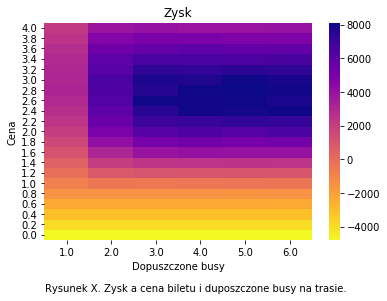

In [20]:

test_pivoted=data2.pivot("Cena","Dopuszczone busy","Zysk")
ax=sns.heatmap(test_pivoted, cmap=cm.plasma_r)
ax.invert_yaxis()
ax.set_title('Zysk')
ax.text(0.01, -5, "Rysunek X. Zysk a cena biletu i duposzczone busy na trasie.", ha='left')
plt.show()

## 6. Analiza wrażliwości

<br> W tej części raportu zostanie przeprowadzona analiza skutków zmiany wybranych kluczowych parametrów. Pomoże to odpowiedzieć na pytanie, jak zmiana parametrów wpłynie na rozwiązanie optymalne.